In [116]:
import nibabel as nib
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from pathlib import Path
from ipywidgets import IntSlider, interact
import pywt
import cv2
import dicom2nifti
from skimage import exposure

In [117]:
def plot_img(img, cmap = 'gray'):
    plt.figure(figsize=(12,8))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

In [118]:
#convert dicom to nii.gz
#dicom2nifti.dicom_series_to_nifti('0_1', '0_1.nii.gz', reorient_nifti=True)

In [119]:
#download 3d brain image
brain = nib.load('0_1.nii.gz')

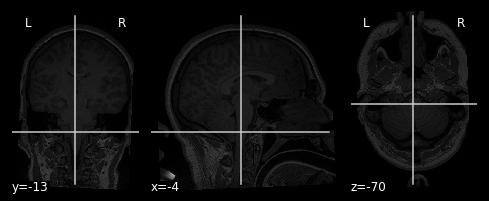

In [120]:
plot_anat(brain)

In [121]:
brain = brain.get_fdata()
brain.shape

(192, 352, 352)

In [122]:
sld_sagital = IntSlider(min=0, max=brain.shape[0]-1, step=1, continuous_update=True)
sld_coronal = IntSlider(min=0, max=brain.shape[1]-1, step=1, continuous_update=True)
sld_axial   = IntSlider(min=0, max=brain.shape[2]-1, step=1, continuous_update=True)

In [123]:
def vary_coordinate(coordinate_sagital, coordinate_coronal, coordinate_axial, axis = None):
    if axis == None:
        pass
    if axis == 'sagital':
        plot_img(brain[coordinate_sagital,:,:])
    if axis == 'coronal':
        plot_img(brain[:,coordinate_coronal ,:])
    if axis == 'axial':
        plot_img(brain[:,:, coordinate_axial])

In [124]:
interact(vary_coordinate, 
         coordinate_axial = sld_axial,
         coordinate_sagital = sld_sagital,
         coordinate_coronal = sld_coronal,
         axis = 'axial')

interactive(children=(IntSlider(value=0, description='coordinate_sagital', max=191), IntSlider(value=0, descri…

<function __main__.vary_coordinate(coordinate_sagital, coordinate_coronal, coordinate_axial, axis=None)>

In [125]:
#We consider only one slice
A1 = brain[:,:,225].T

In [126]:
print(f'mean = {A1.mean()}')
print(f'variance = {A1.var()}')

mean = 211.5997869318182
variance = 25163.32228096786


In [127]:
#GLobal histogram equalization
A1_to_cv = np.uint8(cv2.normalize(A1, None, 0, 255, cv2.NORM_MINMAX))
A2 = cv2.equalizeHist(A1_to_cv)

#Local histogram equalization
#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#A2 = clahe.apply(A1_to_cv)

In [128]:
print(f'mean = {A2.mean()}')
print(f'variance = {A2.var()}')

mean = 124.1417939157197
variance = 5620.130063164442


In [129]:
A1 = cv2.resize(A1, (256, 256))
A2 = cv2.resize(A2, (256, 256))

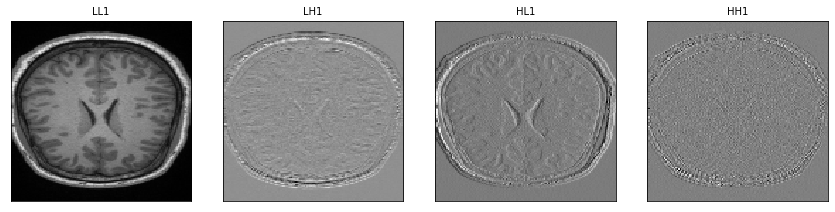

In [130]:
titles = ['LL1', 'LH1', 'HL1', 'HH1']

w = pywt.Wavelet('db1')
coeffs = pywt.dwt2(A1, w)

LL1, (LH1, HL1, HH1) = coeffs

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL1, LH1, HL1, HH1]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()



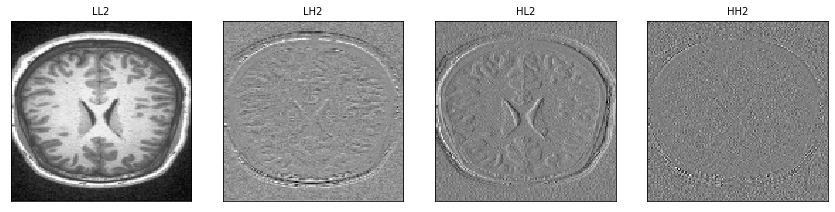

In [131]:
titles = ['LL2', 'LH2', 'HL2', 'HH2']

w = pywt.Wavelet('db1')
coeffs = pywt.dwt2(A2, w)

LL2, (LH2, HL2, HH2) = coeffs

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL2, LH2, HL2, HH2]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()


## SVD of LL's 

In [132]:
U1, S1, V1 = np.linalg.svd(LL1, full_matrices = False)
U2, S2, V2 = np.linalg.svd(LL2, full_matrices = False)

## Different methods of finding $\xi$

In [133]:
xi_1 = S2[0]/S1[0]

In [134]:
xi_2 = U2.max()/U1.max()

In [135]:
xi_3 = (U2.max() + V2.max())/(U1.max() + V1.max())

## New $\Sigma$ 

In [136]:
def new_sigma1(sigma2, xi):
    return xi*sigma2

In [137]:
def new_sigma2(sigma1, sigma2, xi):
    return 0.5*(xi*sigma1+sigma2/xi)

In [138]:
def new_sigma3(sigma1, sigma2, xi, mu):
    return mu*xi*sigma1 + (1-mu)*sigma2/xi

## New LL 

In [139]:
def new_LL(new_sigma):
    new_sigma = np.diag(new_sigma)
    return U2 @ new_sigma @ V2

## Experiments with different approaches

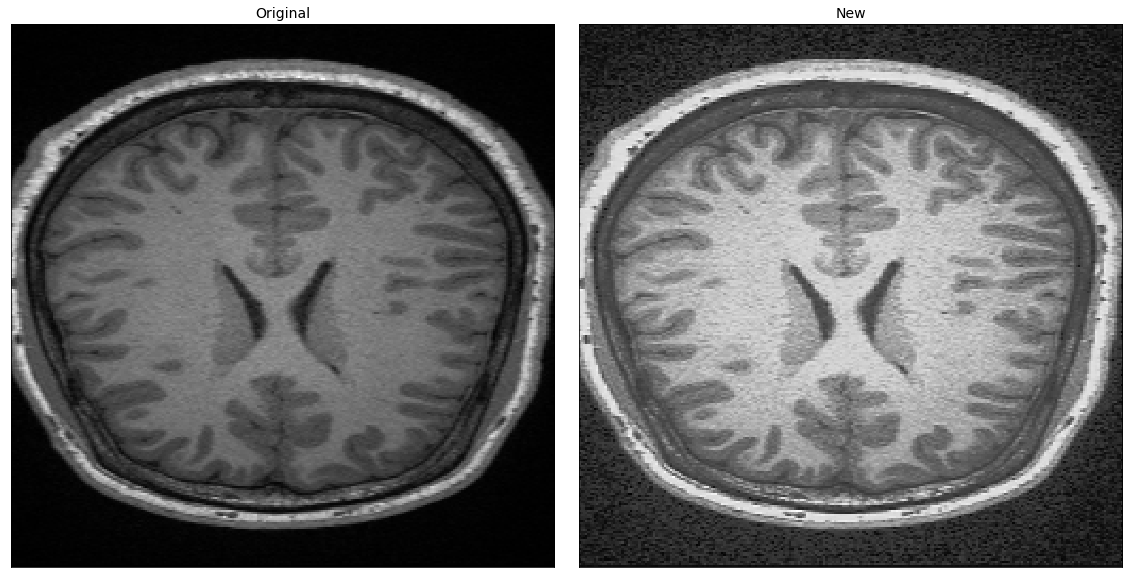

In [140]:
# Article of 2014
new_S = new_sigma1(S2, xi_2)
LL = new_LL(new_S)
brain1 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate([A1, brain1]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

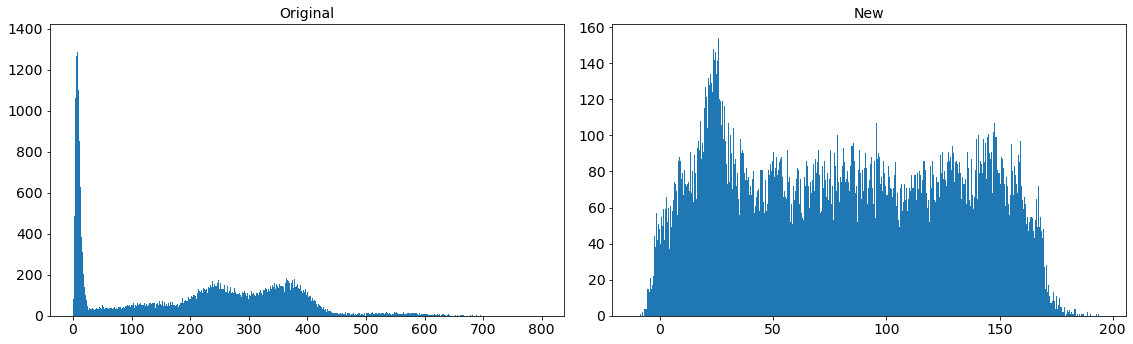

In [141]:
titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 5))
for i, a in enumerate([A1, brain1]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(a.reshape(-1), bins = 1000)
    ax.set_title(titles[i], fontsize=14)
fig.tight_layout()
plt.show()

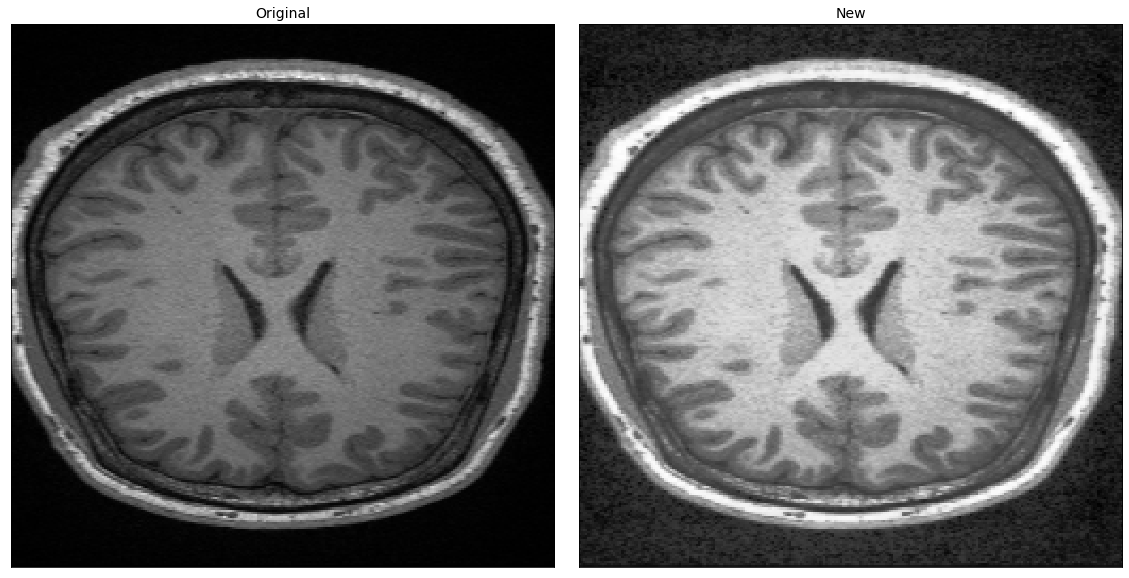

In [142]:
# Article of 2015
new_S = new_sigma2(S1, S2, xi_3)
LL = new_LL(new_S)
brain2 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate([A1, brain2]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

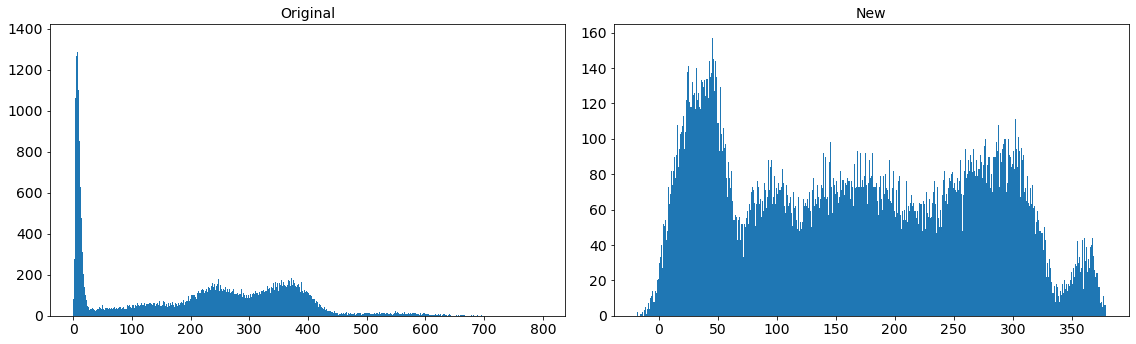

In [143]:
titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 5))
for i, a in enumerate([A1, brain2]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(a.reshape(-1), bins = 1000)
    ax.set_title(titles[i], fontsize=14)
fig.tight_layout()
plt.show()

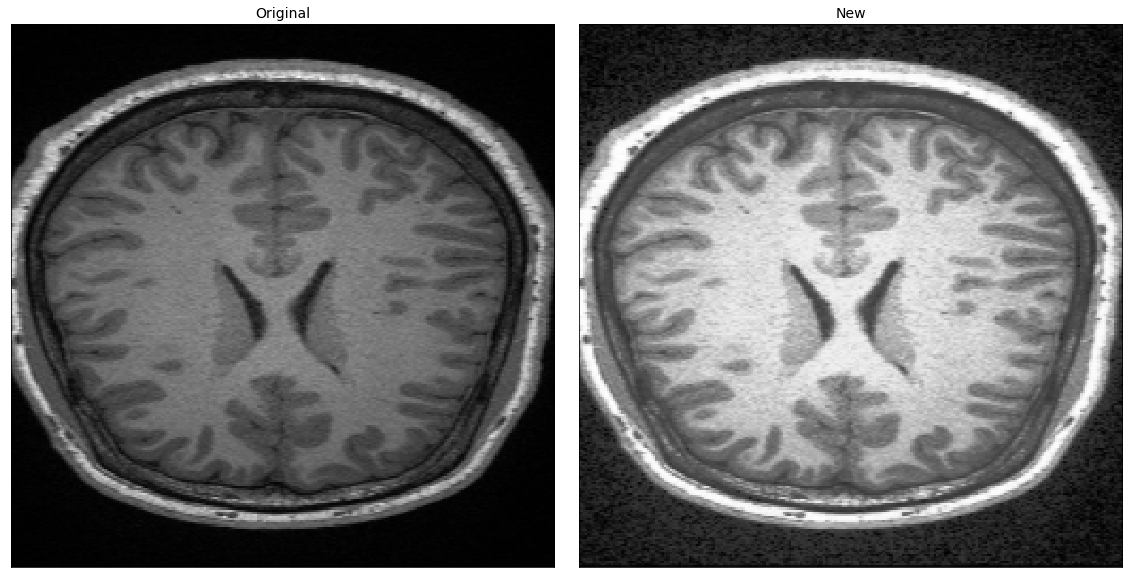

In [144]:
# Main article

mu = 0.1
new_S = new_sigma3(S1, S2, xi_3, mu)
LL = new_LL(new_S)
brain3 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate([A1, brain3]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

In [145]:
brains_3 = []
for mu in np.linspace(0,1, 20):
    new_S = new_sigma3(S1, S2, xi_3, mu)
    LL = new_LL(new_S)
    brains_3.append(pywt.idwt2((LL, (LH2, HL2, HH2)), w))

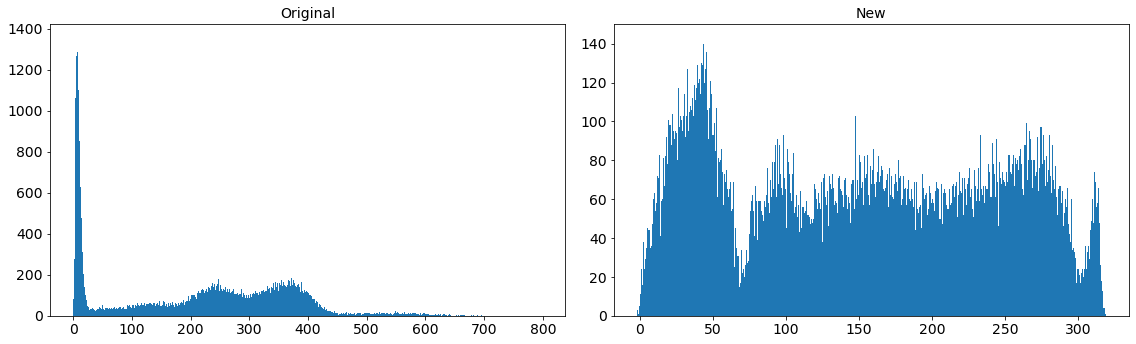

In [146]:
titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 5))
for i, a in enumerate([A1, brain3]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(a.reshape(-1), bins = 1000)
    ax.set_title(titles[i], fontsize=14)
fig.tight_layout()
plt.show()

## Alternative methods

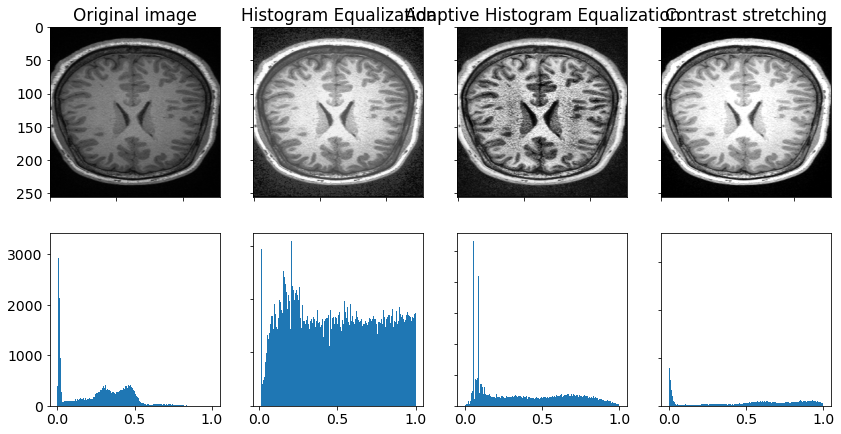

In [147]:
image = A1/A1.max()
image_eq = exposure.equalize_hist(image)
image_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)
pd, pu = np.percentile(image, (8, 92))
image_rescale = exposure.rescale_intensity(image, in_range=(pd, pu))


fig, axs = plt.subplots(2, 4,figsize = (14,7))
axs[0, 0].imshow(image, cmap = 'gray')
axs[0, 0].set_title('Original image')
axs[0, 1].imshow(image_eq, cmap = 'gray')
axs[0, 1].set_title('Histogram Equalization')
axs[0, 2].set_title('Adaptive Histogram Equalization')
axs[0, 2].imshow(image_adapteq, cmap = 'gray')
axs[0, 3].set_title('Contrast stretching')
axs[0, 3].imshow(image_rescale, cmap = 'gray')

axs[1, 0].hist(image.reshape(-1), bins = 400)
axs[1, 1].hist(image_eq.reshape(-1), bins = 400)
axs[1, 2].hist(image_adapteq.reshape(-1), bins = 400)
axs[1, 3].hist(image_rescale.reshape(-1), bins = 400)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Plotting

(0.0, 1.0, 0.0, 1.0)

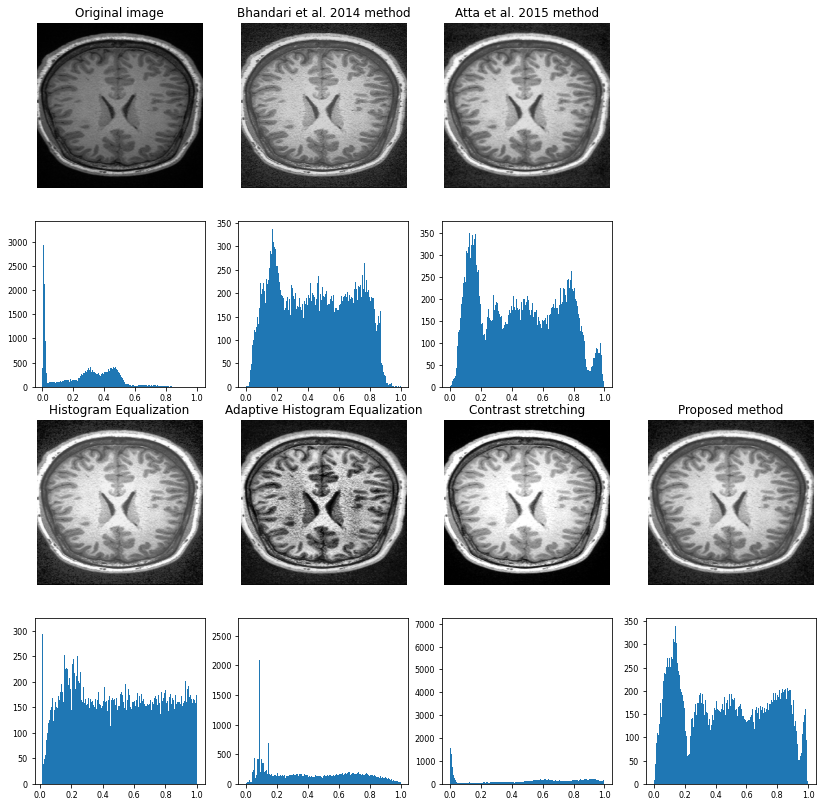

In [148]:
brain1 = (brain1 - brain1.min())/(brain1.max() - brain1.min())
brain2 = (brain2 - brain2.min())/(brain2.max() - brain2.min())
brain3 = (brain3 - brain3.min())/(brain3.max() - brain3.min())

plt.rc('font', size = 8)
fig, axs = plt.subplots(4, 4,figsize = (14,14))
axs[0, 0].imshow(image, cmap = 'gray')
axs[0, 0].set_title('Original image', fontsize = 12)
axs[0, 0].axis('off')
axs[0, 1].imshow(brain1, cmap = 'gray')
axs[0, 1].set_title('Bhandari et al. 2014 method', fontsize = 12)
axs[0, 1].axis('off')
axs[0, 2].set_title('Atta et al. 2015 method', fontsize = 12)
axs[0, 2].imshow(brain2, cmap = 'gray')
axs[0, 2].axis('off')
axs[2, 3].set_title('Proposed method', fontsize = 12)
axs[2, 3].imshow(brain3, cmap = 'gray')
axs[2, 3].axis('off')

axs[1, 0].hist(image.reshape(-1), bins = 400)
axs[1, 1].hist(brain1.reshape(-1), bins = 400)
axs[1, 2].hist(brain2.reshape(-1), bins = 400)


axs[2, 0].set_title('Histogram Equalization', fontsize = 12)
axs[2, 0].imshow(image_eq, cmap = 'gray')
axs[2, 0].axis('off')
axs[2, 1].set_title('Adaptive Histogram Equalization', fontsize = 12)
axs[2, 1].imshow(image_adapteq, cmap = 'gray')
axs[2, 1].axis('off')
axs[2, 2].set_title('Contrast stretching', fontsize = 12)
axs[2, 2].imshow(image_rescale, cmap = 'gray')
axs[2, 2].axis('off')
axs[0, 3].axis('off')

axs[3, 0].hist(image_eq.reshape(-1), bins = 400)
axs[3, 1].hist(image_adapteq.reshape(-1), bins = 400)
axs[3, 2].hist(image_rescale.reshape(-1), bins = 400)
axs[3, 3].hist(brain3.reshape(-1), bins = 400)
axs[1, 3].axis('off')

## Metrics

In [149]:
import imp
#from metrics import psnr, ssim
import metrics
imp.reload(metrics)

<module 'metrics' from 'C:\\Users\\lsarz\\Documents\\5th year\\Sk_term2\\Skoltech-NLA-MRI\\metrics.py'>

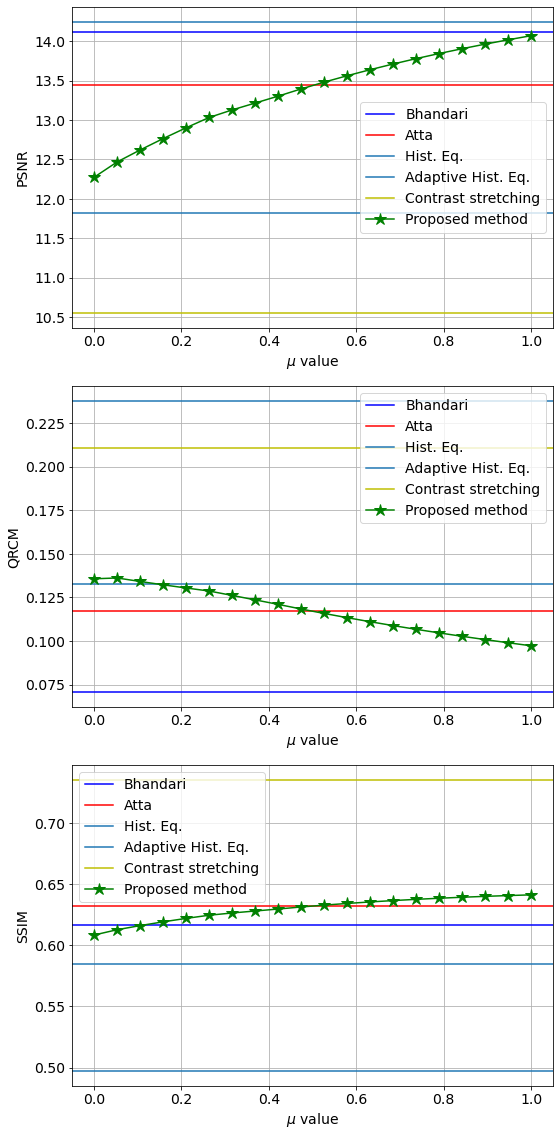

In [163]:
titles = ['PSNR', 'QRCM', 'SSIM']
fig = plt.figure(figsize=(8, 16))
plt.rc('font', **{'size':14})
for i, func in enumerate([metrics.psnr, metrics.qrcm, metrics.ssim]):
    ax = fig.add_subplot(3, 1, i + 1)
    ax.axhline(func(A1, brain1), color = 'b', label = 'Bhandari')
    ax.axhline(func(A1, brain2), color = 'r', label = 'Atta')
    ax.axhline(func(A1, image_eq), label = 'Hist. Eq.')
    ax.axhline(func(A1, image_adapteq), label = 'Adaptive Hist. Eq.')
    ax.axhline(func(A1, image_rescale), color = 'y', label = 'Contrast stretching')
    ax.plot(np.linspace(0,1,20), [func(A1,x) for x in brains_3], '*-', markersize=12, color = 'g', label = 'Proposed method')
    ax.set_xlabel('$\mu$ value')
    ax.legend(loc = 'best')
    ax.set_ylabel(titles[i])
    ax.grid(True)
fig.tight_layout()
plt.show()